In [13]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

In [15]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [16]:
info_col_cl =  info_col+['class']

In [17]:
data_imp_v2 = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv' , index_col='obs_id')

In [18]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


In [19]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.600161,0.007931,0.002263,0.002978,0.001218,0.515405,0.523568,5.00,3.07375,5.417707e-04
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.636945,0.004085,0.001735,0.002451,0.000613,0.614881,0.574516,5.00,3.00000,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.677229,0.004417,0.001721,0.002179,0.000574,0.665955,0.543535,3.00,4.00000,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,0.353444,0.004808,0.003408,0.003737,0.000345,0.381742,0.226397,6.00,8.00000,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.746582,0.005740,0.002950,0.003574,0.000689,0.606845,0.558287,3.00,4.00000,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.539000,0.003494,0.003420,0.003456,0.000029,0.829000,0.084000,5.11,3.03000,2.125299e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.211000,0.003517,0.001060,0.001171,0.000255,0.265000,0.807000,5.00,3.03000,2.151511e-05
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,0.547000,0.002756,0.001488,0.001623,0.000211,0.735000,0.451000,3.00,5.00000,8.482809e-07


In [20]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.140383,-0.193753,-0.407606,-0.409996,0.042725,-0.250447,0.492569,0.200236,-0.756434,0.168818
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.300193,-0.422380,-0.452348,-0.450546,-0.153447,0.182504,0.710415,0.200236,-0.795530,-0.096487
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.475208,-0.402661,-0.453504,-0.471439,-0.166164,0.404797,0.577944,-0.948770,-0.265416,-0.096436
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,-0.931496,-0.379399,-0.310762,-0.351673,-0.240642,-0.832196,-0.778104,0.774739,1.855039,-0.096581
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.776519,-0.324030,-0.349557,-0.364175,-0.128738,0.147528,0.641022,-0.948770,-0.265416,-0.096428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,-0.125336,-0.457551,-0.309760,-0.373279,-0.343210,1.114425,-1.386978,0.263431,-0.779626,-0.086540
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,-1.550353,-0.456183,-0.509419,-0.548922,-0.269642,-1.340299,1.704492,0.200236,-0.779626,-0.086412
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,-0.090579,-0.501432,-0.473210,-0.514178,-0.283957,0.705305,0.182274,-0.948770,0.264698,-0.096551


In [21]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (420, 59)
Number of sources : 
CV  	  184 	 184
PL  	  178 	 178
LX  	  58 	 58


In [22]:
verbose = 0
val_acc = []
test_acc = []
for i in tqdm(range(32)):
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.2 , stratify=y_val, random_state=42)
    clf = RandomForestClassifier(n_estimators=200 , )
    clf.fit(x_train , y_train ,sample_weight=i_train['significance'])
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(test_sc , v_sc)

  3%|▎         | 1/32 [00:00<00:18,  1.71it/s]

0.9910714285714286 0.7380952380952381


  6%|▋         | 2/32 [00:01<00:19,  1.52it/s]

0.9910714285714286 0.7380952380952381


  9%|▉         | 3/32 [00:01<00:18,  1.58it/s]

0.9910714285714286 0.7619047619047619


 12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

0.9910714285714286 0.7380952380952381


 16%|█▌        | 5/32 [00:02<00:14,  1.82it/s]

0.9910714285714286 0.7380952380952381


 19%|█▉        | 6/32 [00:03<00:13,  1.90it/s]

0.9910714285714286 0.7261904761904762


 22%|██▏       | 7/32 [00:03<00:12,  1.98it/s]

0.9910714285714286 0.7619047619047619


 25%|██▌       | 8/32 [00:04<00:11,  2.05it/s]

0.9910714285714286 0.7023809523809523


 28%|██▊       | 9/32 [00:04<00:10,  2.12it/s]

0.9910714285714286 0.7261904761904762


 31%|███▏      | 10/32 [00:05<00:10,  2.15it/s]

0.9910714285714286 0.7023809523809523


 34%|███▍      | 11/32 [00:05<00:09,  2.17it/s]

0.9910714285714286 0.7261904761904762


 38%|███▊      | 12/32 [00:06<00:09,  2.19it/s]

0.9910714285714286 0.7023809523809523


 41%|████      | 13/32 [00:06<00:08,  2.20it/s]

0.9910714285714286 0.7142857142857143


 44%|████▍     | 14/32 [00:06<00:08,  2.21it/s]

0.9910714285714286 0.7619047619047619


 47%|████▋     | 15/32 [00:07<00:07,  2.22it/s]

0.9910714285714286 0.75


 50%|█████     | 16/32 [00:07<00:07,  2.23it/s]

0.9910714285714286 0.7261904761904762


 53%|█████▎    | 17/32 [00:08<00:06,  2.23it/s]

0.9910714285714286 0.7261904761904762


 56%|█████▋    | 18/32 [00:08<00:06,  2.23it/s]

0.9910714285714286 0.7142857142857143


 59%|█████▉    | 19/32 [00:09<00:05,  2.24it/s]

0.9910714285714286 0.7619047619047619


 62%|██████▎   | 20/32 [00:09<00:05,  2.24it/s]

0.9910714285714286 0.7380952380952381


 66%|██████▌   | 21/32 [00:10<00:04,  2.24it/s]

0.9910714285714286 0.7023809523809523


 69%|██████▉   | 22/32 [00:10<00:04,  2.25it/s]

0.9910714285714286 0.7380952380952381


 72%|███████▏  | 23/32 [00:10<00:03,  2.25it/s]

0.9910714285714286 0.7142857142857143


 75%|███████▌  | 24/32 [00:11<00:03,  2.26it/s]

0.9910714285714286 0.7380952380952381


 78%|███████▊  | 25/32 [00:11<00:03,  2.26it/s]

0.9910714285714286 0.6904761904761905


 81%|████████▏ | 26/32 [00:12<00:02,  2.24it/s]

0.9910714285714286 0.7261904761904762


 84%|████████▍ | 27/32 [00:12<00:02,  2.24it/s]

0.9910714285714286 0.75


 88%|████████▊ | 28/32 [00:13<00:01,  2.24it/s]

0.9910714285714286 0.7380952380952381


 91%|█████████ | 29/32 [00:13<00:01,  2.25it/s]

0.9910714285714286 0.7142857142857143


 94%|█████████▍| 30/32 [00:14<00:00,  2.26it/s]

0.9910714285714286 0.7261904761904762


 97%|█████████▋| 31/32 [00:14<00:00,  2.24it/s]

0.9910714285714286 0.7738095238095238


100%|██████████| 32/32 [00:14<00:00,  2.13it/s]

0.9910714285714286 0.7380952380952381


In [25]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,99.107143,73.139881
std,0.000000,2.049456
min,99.107143,69.047619
max,99.107143,77.380952


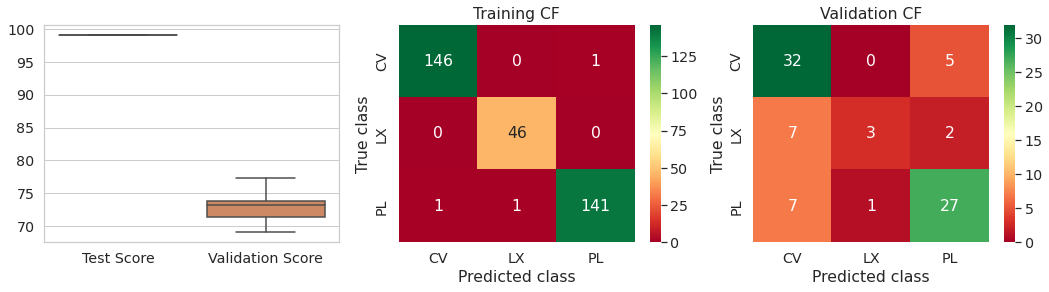

In [29]:
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=3 , figsize = (18 , 4))
sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(y_train , clf.predict(x_train) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels =class_to_select , yticklabels = class_to_select  , cmap='RdYlGn' ,)
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[2] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='RdYlGn')
ax[1].set_title('Training CF')
ax[2].set_title('Validation CF')
for a in ax[1:]:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')

plt.show()
#score